FINAL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/output.csv")
print("Shape:", df.shape)
df.head()

Shape: (277, 27)


,filename,procdump,dropped,processes,files,read_files,write_files,delete_files,keys,read_keys,...,domains,tcp,udp,icmp,http,dns,dead_hosts,signatures_count,ttps_count,status
0,1.json,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,benign
1,10.json,2,1,2,42,0,0,2,217,143,...,2,175,58,1,1,2,0,11,6,malicious
2,100.json,1,1,2,0,0,0,0,0,0,...,0,234,83,2,0,0,0,7,3,malicious
3,101.json,1,1,2,0,0,0,0,0,0,...,0,0,613,0,0,0,0,7,3,malicious
4,102.json,1,1,2,0,0,0,0,0,0,...,0,0,628,1,0,0,0,7,3,malicious


In [3]:
df.describe()

,procdump,dropped,processes,files,read_files,write_files,delete_files,keys,read_keys,write_keys,...,hosts,domains,tcp,udp,icmp,http,dns,dead_hosts,signatures_count,ttps_count
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,...,277.000000,277.000000,277.000000,277.000000,277.000000,277.00000,277.000000,277.000000,277.000000,277.000000
mean,0.992780,1.411552,3.425993,38.909747,0.924188,0.960289,0.324910,351.375451,223.519856,6.783394,...,4.259928,1.382671,68.848375,143.974729,7.534296,4.65704,1.393502,1.501805,6.620939,4.169675
std,7.574266,11.907719,9.090075,105.449121,7.603253,7.607339,1.249287,1148.763212,757.825544,49.423965,...,7.797084,2.784166,117.399967,320.395537,18.924997,12.04256,2.788504,3.634202,7.872903,5.180449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,33.000000,0.000000,0.00000,0.000000,0.000000,3.000000,2.000000
75%,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,2.000000,94.000000,97.000000,3.000000,1.00000,2.000000,1.000000,10.000000,6.000000
max,90.000000,163.000000,90.000000,1142.000000,90.000000,90.000000,13.000000,9056.000000,5216.000000,784.000000,...,50.000000,23.000000,687.000000,3439.000000,129.000000,81.00000,23.000000,18.000000,37.000000,28.000000


In [4]:
# 2. Drop non‑predictive column
df.drop(columns=['filename'], inplace=True)

In [5]:
le = LabelEncoder()
df['status_enc'] = le.fit_transform(df['status'])  # benign=0, malicious=1, suspicious=2
y = df['status_enc']
print("Class counts:\n", y.value_counts())

Class counts:
 status_enc
0    173
1     75
2     29
Name: count, dtype: int64


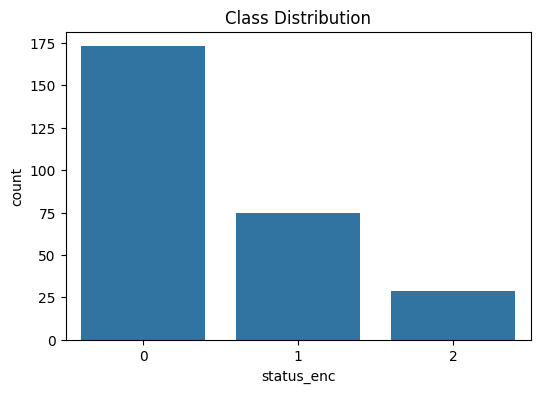

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Distribution"); plt.show()

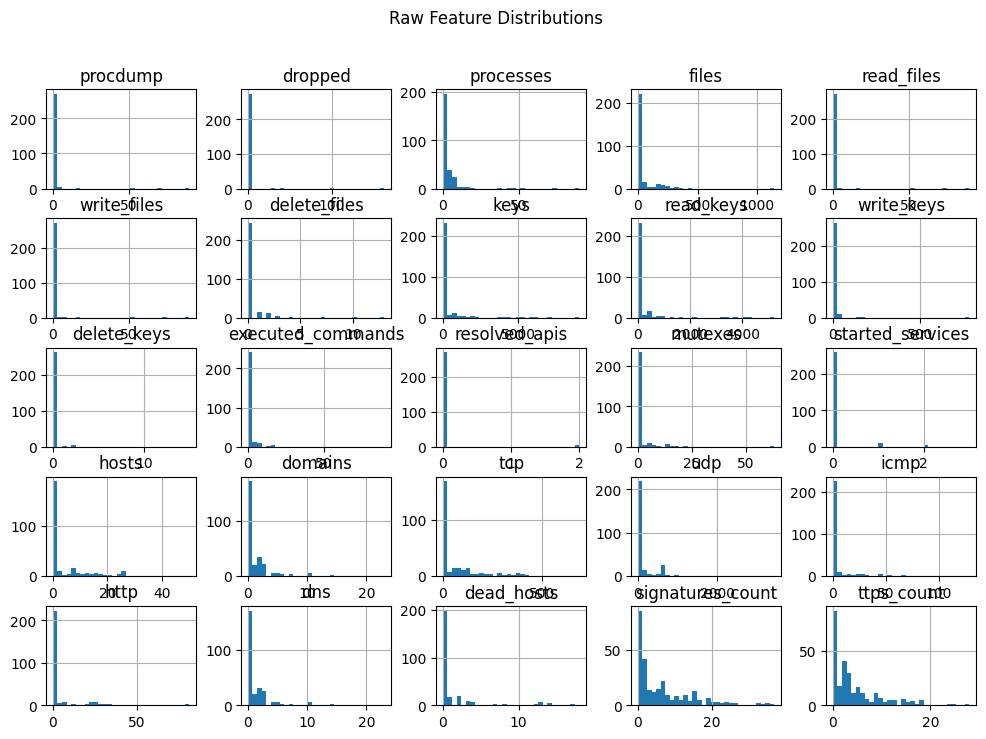

In [7]:
# Histograms (log scale bins)
X_raw = df.drop(columns=['status','status_enc'])
X_raw.hist(bins=30, figsize=(12,8))
plt.suptitle("Raw Feature Distributions"); plt.show()

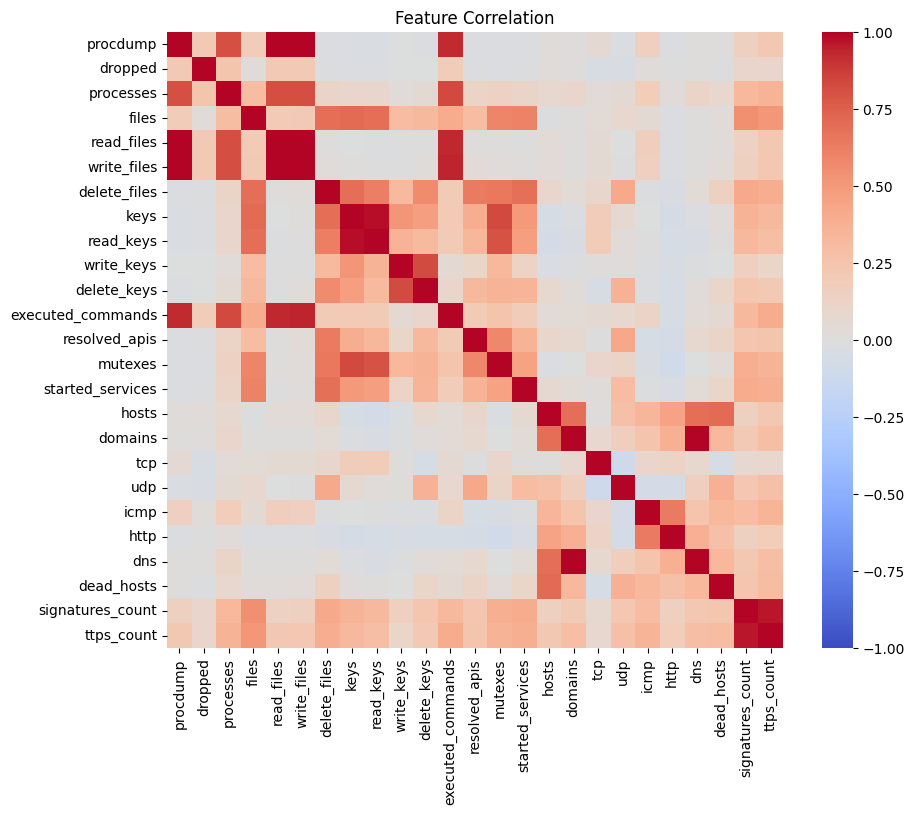

In [8]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X_raw.corr(), cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.title("Feature Correlation"); plt.show()

In [9]:
# 5. Preprocessing
# 5.1 Log1p transform
X = np.log1p(X_raw)
# 5.2 Check & fill missing
print("Missing per column:\n", X.isna().sum().sum())
X.fillna(X.median(), inplace=True)

Missing per column:
 0


In [10]:
# 5.3 Train‑test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# 5.4 Handle imbalance with SMOTE on train
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [12]:
# 5.5 Scaling (for classifiers that need it)
scaler = StandardScaler()
X_train_res_s = scaler.fit_transform(X_train_res)
X_test_s       = scaler.transform(X_test)

In [13]:
# 6. Cross‑Validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
# 7. Define models + hyperparameter grids
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        {"C":[0.01,0.1,1,10], "solver":["lbfgs"]}
    ),
    "SVM": (
        SVC(class_weight='balanced', probability=True),
        {"C":[0.1,1,10], "kernel":["rbf","linear"], "gamma":["scale","auto"]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        {"max_depth":[None,5,10], "min_samples_split":[2,5,10]}
    ),
    "Random Forest": (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        {"n_estimators":[50,100], "max_depth":[None,5,10]}
    ),
    "XGBoost": (
        xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
        {"n_estimators":[50,100], "max_depth":[3,5], "learning_rate":[0.01,0.1]}
    ),
    "Naive Bayes": (
        GaussianNB(),
        {"var_smoothing":[1e-9,1e-8,1e-7]}
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {"n_estimators":[50,100], "learning_rate":[0.5,1.0]}
    )
}

results = []
best_clfs={}

In [15]:
# 8. GridSearchCV + 10‑fold CV for each
for name, (model, params) in models.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    # NB: for tree‑based and NB we can use X_train_res directly; for others use scaled
    X_in = X_train_res_s if name in ["Logistic Regression","SVM"] else X_train_res
    gs.fit(X_in, y_train_res)
    print("Best CV Accuracy:", gs.best_score_)
    print("Best Params:", gs.best_params_)
    # Evaluate on test set
    clf = gs.best_estimator_
    best_clfs[f"{name}"]=clf
    X_tst = X_test_s if name in ["Logistic Regression","SVM"] else X_test
    y_pred = clf.predict(X_tst)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    results.append((name, gs.best_score_, accuracy_score(y_test,y_pred)))



=== Logistic Regression ===
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best CV Accuracy: 0.9323461091753774
Best Params: {'C': 1, 'solver': 'lbfgs'}
Test Accuracy: 0.8214285714285714
              precision    recall  f1-score   support

      benign       0.97      0.86      0.91        35
   malicious       0.71      0.80      0.75        15
  suspicious       0.50      0.67      0.57         6

    accuracy                           0.82        56
   macro avg       0.72      0.77      0.74        56
weighted avg       0.85      0.82      0.83        56


=== SVM ===
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best CV Accuracy: 0.9540650406504063
Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Test Accuracy: 0.8392857142857143
              precision    recall  f1-score   support

      benign       0.94      0.89      0.91        35
   malicious       0.76      0.87      0.81        15
  suspicious       0.50      0.50      0.50       

In [16]:
# 9. Clustering (K‑Means) separately
print("\n=== K‑Means Clustering ===")
# try cluster counts around true #classes=3
sil_scores = {}
for k in [2,3,4,5]:
    km = KMeans(n_clusters=k, random_state=42)
    lbls = km.fit_predict(X_train_res_s)
    sil = silhouette_score(X_train_res_s, lbls)
    sil_scores[k] = sil
    print(f"k={k} silhouette={sil:.3f}")
best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)


=== K‑Means Clustering ===
k=2 silhouette=0.269
k=3 silhouette=0.338
k=4 silhouette=0.370
k=5 silhouette=0.366
Best k by silhouette: 4


In [17]:
results_df = pd.DataFrame(results, columns=["Model","CV_Accuracy","Test_Accuracy"])
display(results_df.sort_values("Test_Accuracy", ascending=False))

,Model,CV_Accuracy,Test_Accuracy
1,SVM,0.954065,0.839286
3,Random Forest,0.966202,0.839286
0,Logistic Regression,0.932346,0.821429
2,Decision Tree,0.934785,0.803571
4,XGBoost,0.968467,0.785714
6,AdaBoost,0.930081,0.767857
5,Naive Bayes,0.705110,0.660714


In [18]:
ensemble_results=[]
#10. Voting Ensemble with best classifier of each category
from sklearn.ensemble import VotingClassifier
votingclf=VotingClassifier(estimators=[])
for name,clf in best_clfs.items():
  votingclf.estimators.append((f'{name}',clf))
gs = GridSearchCV(
        estimator=votingclf,
        param_grid={"voting": ["hard","soft"]},
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
gs.fit(X_train_res_s, y_train_res)
print("Best CV Accuracy:", gs.best_score_)
print("Best Params:", gs.best_params_)
clf = gs.best_estimator_
y_pred = clf.predict(X_test_s)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
ensemble_results.append(("Voting with all clfs", gs.best_score_, accuracy_score(y_test,y_pred)))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best CV Accuracy: 0.9660859465737515
Best Params: {'voting': 'hard'}
Test Accuracy: 0.8214285714285714
              precision    recall  f1-score   support

      benign       0.89      0.91      0.90        35
   malicious       0.75      0.80      0.77        15
  suspicious       0.50      0.33      0.40         6

    accuracy                           0.82        56
   macro avg       0.71      0.68      0.69        56
weighted avg       0.81      0.82      0.81        56



In [19]:
#11. Voting Ensemble with SVM, RF and LR
from sklearn.ensemble import VotingClassifier
votingclf=VotingClassifier(estimators=[])
for name,clf in best_clfs.items():
  if(name in ["Logistic Regression", "SVM", "Random Forest"]):
    votingclf.estimators.append((f'{name}',clf))
votingclf
gs = GridSearchCV(
        estimator=votingclf,
        param_grid={"voting": ["hard","soft"]},
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
gs.fit(X_train_res_s, y_train_res)
print("Best CV Accuracy:", gs.best_score_)
print("Best Params:", gs.best_params_)
clf = gs.best_estimator_
y_pred = clf.predict(X_test_s)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
ensemble_results.append(("Voting with SVM, RF, LR", gs.best_score_, accuracy_score(y_test,y_pred)))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Best CV Accuracy: 0.9637630662020905
Best Params: {'voting': 'hard'}
Test Accuracy: 0.8392857142857143
              precision    recall  f1-score   support

      benign       0.94      0.89      0.91        35
   malicious       0.76      0.87      0.81        15
  suspicious       0.50      0.50      0.50         6

    accuracy                           0.84        56
   macro avg       0.73      0.75      0.74        56
weighted avg       0.85      0.84      0.84        56



In [20]:
#12. Bagging Ensemble with SVM
from sklearn.ensemble import BaggingClassifier
baggingclf=BaggingClassifier(estimator=best_clfs["SVM"])
params={
    "n_estimators":[5, 10],
    "max_samples":[0.5, 0.75, 1.0],
    "max_features":[0.5, 0.75, 1.0],
    "bootstrap":[True,False],
    "bootstrap_features":[True,False],
    "random_state":[42]
}
gs = GridSearchCV(
        estimator=baggingclf,
        param_grid=params,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
gs.fit(X_train_res_s, y_train_res)
print("Best CV Accuracy:", gs.best_score_)
print("Best Params:", gs.best_params_)
clf = gs.best_estimator_
y_pred = clf.predict(X_test_s)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
ensemble_results.append(("Bagging with SVM", gs.best_score_, accuracy_score(y_test,y_pred)))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best CV Accuracy: 0.9516260162601625
Best Params: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 5, 'random_state': 42}
Test Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

      benign       0.97      0.86      0.91        35
   malicious       0.78      0.93      0.85        15
  suspicious       0.57      0.67      0.62         6

    accuracy                           0.86        56
   macro avg       0.77      0.82      0.79        56
weighted avg       0.87      0.86      0.86        56



In [21]:
ensemble_results_df = pd.DataFrame(ensemble_results, columns=["Model","CV_Accuracy","Test_Accuracy"])
display(ensemble_results_df.sort_values("Test_Accuracy", ascending=False))

,Model,CV_Accuracy,Test_Accuracy
2,Bagging with SVM,0.951626,0.857143
1,"Voting with SVM, RF, LR",0.963763,0.839286
0,Voting with all clfs,0.966086,0.821429
